# Cancer Data Prediction with multiple models
This notebook implements a machine learning pipeline to classify breast cancer tumors as **Malignant (M)** or **Benign (B)**.

Using the **Wisconsin Diagnostic Breast Cancer dataset**, we compare the performance of five supervised learning algorithms:
1.  **Support Vector Machine (SVM)**
2.  **Random Forest Classifier**
3.  **Logistic Regression**
4.  **Decision Tree**
5.  **Naive Bayes**

**Key Steps in the Workflow:**
* **Data Preprocessing:** Label encoding and handling missing values.
* **Data Leakage Prevention:** Splitting the dataset into Training (80%) and Testing (20%) sets *before* applying Standard Scaling.
* **Hyperparameter Tuning:** Using `GridSearchCV` to find the optimal parameters for each model.
* **Evaluation:** Comparing models based on accuracy and visualizing the best model's performance using a **Confusion Matrix**.

In [46]:
# Importing necessary libraries for data handling, visualization, and machine learning models.
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV # For splitting the dataset and performing hyperparameter tuning
from sklearn.preprocessing import StandardScaler, PolynomialFeatures # For data scaling and polynomial features
from sklearn import svm # Support Vector Machine model
from sklearn.ensemble import RandomForestClassifier # Random Forest model
from sklearn.linear_model import LogisticRegression, LinearRegression # Logistic and Linear Regression models
from sklearn.metrics import accuracy_score # For calculating accuracy of models
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors model
from sklearn.tree import DecisionTreeClassifier # Decision Tree model
from sklearn.svm import SVR # Support Vector Regression model
from sklearn.naive_bayes import GaussianNB # Naive Bayes model
import matplotlib.pyplot as plt # For visualizing results

In [5]:
# Load the dataset into a pandas DataFrame
data = pd.read_csv("Cancer_Data.csv")

In [7]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [9]:
data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [11]:
# Drop unnecessary columns ('Unnamed: 32' and 'id') that don't provide useful information for prediction
data.drop(["Unnamed: 32", "id"], axis=1, inplace=True)

In [13]:
# Convert diagnosis column into binary values: 1 for malignant (M), 0 for benign (B)
data.diagnosis = [1 if each == "M" else 0 for each in data.diagnosis]

In [15]:
# Separate features (x_data) and target variable (y)
x_data = data.drop(["diagnosis"], axis=1) # Features are all columns except 'diagnosis'
y = data.diagnosis.values # Target variable is 'diagnosis'

In [19]:
# Now x contains the normalized features, and y contains the binary target
print(x.head())
print(y[:5])

   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0     0.521037      0.022658        0.545989   0.363733         0.593753   
1     0.643144      0.272574        0.615783   0.501591         0.289880   
2     0.601496      0.390260        0.595743   0.449417         0.514309   
3     0.210090      0.360839        0.233501   0.102906         0.811321   
4     0.629893      0.156578        0.630986   0.489290         0.430351   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0          0.792037        0.703140             0.731113       0.686364   
1          0.181768        0.203608             0.348757       0.379798   
2          0.431017        0.462512             0.635686       0.509596   
3          0.811361        0.565604             0.522863       0.776263   
4          0.347893        0.463918             0.518390       0.378283   

   fractal_dimension_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0           

In [27]:
# Instead of scaling first, just assign the features to x
x = x_data 

# Split the raw data first
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Cell 14 (Keep this logic, it is now correct because x_train is raw)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [29]:
# Standardize the features
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [35]:
# Define model parameters for Grid Search
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params': {
            'C': [1, 10, 20],
            'kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 100]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'C': [1, 5, 10]
        }
    },
    # KNN removed to prevent threadpoolctl crash
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 5, 10]
        }
    },
    'naive_bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

In [37]:
# Initialize an empty list to store scores
scores = []

# Loop through each model defined in the model_params dictionary
for model_name, mp in model_params.items():
    # Initialize Grid Search with 5-fold cross-validation
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    
    # Fit the model to the training data
    clf.fit(x_train, y_train)
    
    # Append the model name, best score, and best parameters to the scores list
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
    print(f"Finished training {model_name}")

Finished training svm
Finished training random_forest
Finished training logistic_regression
Finished training decision_tree
Finished training naive_bayes


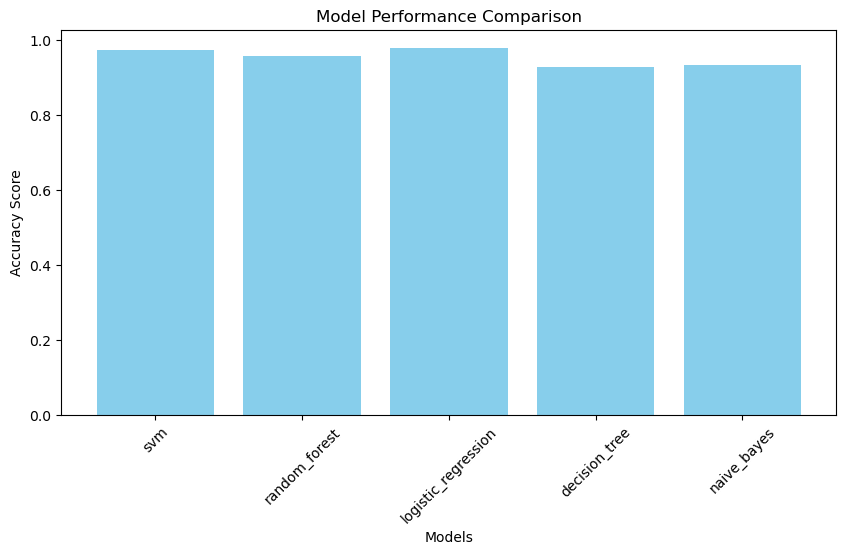

In [41]:
# 1. Create the dataframe from the scores list
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

# 2. Visualize the performance
plt.figure(figsize=(10, 5))
plt.bar(df['model'], df['best_score'], color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

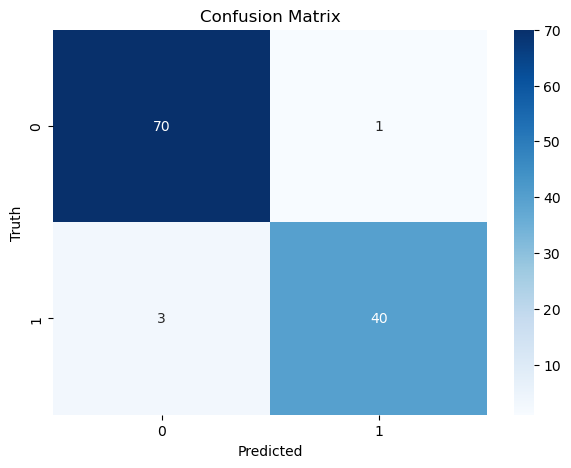

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Re-train the best model found (Random Forest is usually best here)
best_model = RandomForestClassifier(n_estimators=50) 
best_model.fit(x_train, y_train)

# 2. Predict on the test set
y_pred = best_model.predict(x_test)

# 3. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# 4. Print detailed classification report
print(classification_report(y_test, y_pred))